In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import image

from os import listdir
from os.path import isfile, join

import tensorflow as tf

from tensorflow.keras import callbacks, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D
from keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import average_precision_score

2025-10-21 11:29:45.684662: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-21 11:29:45.694691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761038985.707973  839530 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761038985.712438  839530 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-21 11:29:45.725807: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Note: Use conda tf-gpu environment

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
spec_dir = '../data/image_data/'
sample_dir = '../data/image_data/Polistes_dominula/'

paths_sample_plot = [join(sample_dir, f) for f in listdir(sample_dir) if isfile(join(sample_dir, f))]

- (b) View Batch

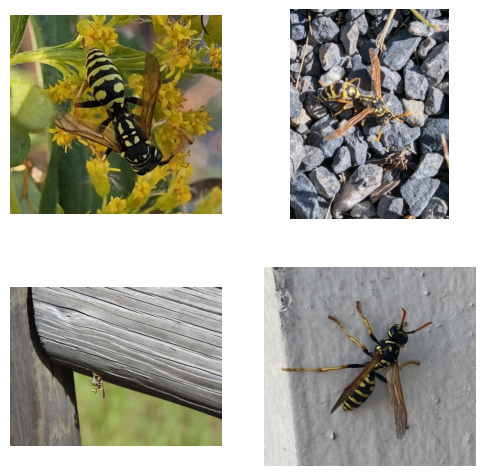

In [4]:
plt.figure(figsize=(6,6))

plt.subplot(221)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(222)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(223)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(224)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]));

Define Batch size

In [5]:
batch_size = 32

## B - <a name="generateurs"></a> Data Generators



In [6]:
train_data_generator = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   )

test_data_generator  = ImageDataGenerator(rescale = 1./255)
data_generator  = ImageDataGenerator(rescale = 1./255)

- (d) Implement ```training_data```, ```valid_data``` splits


In [7]:
training_data  = train_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "training", 
                                                   batch_size = batch_size)

validation_data  = train_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "validation", 
                                                   batch_size = batch_size)

#test_data  = test_data_generator.flow_from_directory(directory = spec_dir,
#                                                   target_size = (224, 224),
#                                                   class_mode = 'binary',
#                                                   batch_size = batch_size)


Found 10989 images belonging to 127 classes.
Found 2726 images belonging to 127 classes.


# II - <a name="classif"></a> Classification



In [ ]:
# Model MobileNet
base_model = MobileNet(weights='imagenet', include_top=False)

# Freezer les couches
for layer in base_model.layers[:-6]:
    layer.trainable = False

model = Sequential()
model.add(base_model) # Ajout du modèl
model.add(GlobalAveragePooling2D())
model.add(Dropout(rate=0.2))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(127, activation='softmax'))

/tmp/ipykernel_839530/4059565619.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False)
I0000 00:00:1761038989.678885  839530 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47179 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:65:00.0, compute capability: 7.5
I0000 00:00:1761038989.679920  839530 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 45503 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:b6:00.0, compute capability: 7.5


In [9]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                                         patience = 4,
                                         mode = 'min',
                                         restore_best_weights = True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                        patience=4,
                                         factor=0.5,
                                         verbose=2,
                                         mode='max',
                                         min_lr = 1e-10)

In [10]:
optimizer = Adam(learning_rate=0.0001) 

In [11]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

class AveragePrecisionCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_generator, num_classes=127):
        super().__init__()
        self.val_generator = val_generator
        self.num_classes = num_classes

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []

        for i in range(len(self.val_generator)):
            x_batch, y_batch = self.val_generator[i]  # y_batch: shape (batch_size,)
            preds = self.model.predict(x_batch, verbose=0)  # preds: shape (batch_size, num_classes)

            y_true.extend(y_batch)
            y_pred.extend(preds)

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # One-hot encode y_true to match y_pred's shape
        y_true_onehot = label_binarize(y_true, classes=range(self.num_classes))

        # Compute average precision per class
        aps = []
        for i in range(self.num_classes):
            ap = average_precision_score(y_true_onehot[:, i], y_pred[:, i])
            aps.append(ap)

        macro_ap = np.mean(aps)
        print(f"\nEpoch {epoch + 1}: val_average_precision = {macro_ap:.4f}")
        logs = logs or {}
        logs['val_average_precision'] = macro_ap


In [12]:
ap_callback = AveragePrecisionCallback(val_generator=validation_data)

In [13]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [14]:
history = model.fit(training_data, validation_data=validation_data, epochs=30, 
                    callbacks=[ap_callback,lr_plateau])

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1761038994.116663  839828 service.cc:148] XLA service 0x76ab0c00b940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761038994.116699  839828 service.cc:156]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
I0000 00:00:1761038994.116706  839828 service.cc:156]   StreamExecutor device (1): Quadro RTX 8000, Compute Capability 7.5
2025-10-21 11:29:54.210614: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1761038994.541905  839828 cuda_dnn.cc:529] Loaded cuDNN version 91200
E0000 00:00:1761038995.919186  839828 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761038996.043641  839828 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. T

128/344 ━━━━━━━━━━━━━━━━━━━━ 32s 150ms/step - accuracy: 0.0212 - loss: 4.9235

E0000 00:00:1761039022.088059  839833 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761039022.211555  839833 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761039024.928027  839833 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761039025.064760  839833 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761039025.186309  839833 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.0378 - loss: 4.7695

E0000 00:00:1761039074.662202  839831 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761039074.785328  839831 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761039077.481695  839831 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761039077.603242  839831 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_average_precision = 0.1259
344/344 ━━━━━━━━━━━━━━━━━━━━ 110s 292ms/step - accuracy: 0.0636 - loss: 4.5469 - val_accuracy: 0.1555 - val_loss: 3.9626 - val_average_precision: 0.1259 - learning_rate: 1.0000e-04
Epoch 2/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.1719 - loss: 3.7520
Epoch 2: val_average_precision = 0.2478
344/344 ━━━━━━━━━━━━━━━━━━━━ 82s 238ms/step - accuracy: 0.1954 - loss: 3.5813 - val_accuracy: 0.2792 - val_loss: 3.1004 - val_average_precision: 0.2478 - learning_rate: 1.0000e-04
Epoch 3/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.2870 - loss: 2.9592
Epoch 3: val_average_precision = 0.3111
344/344 ━━━━━━━━━━━━━━━━━━━━ 85s 246ms/step - accuracy: 0.2958 - loss: 2.8915 - val_accuracy: 0.3331 - val_loss: 2.7475 - val_average_precision: 0.3111 - learning_rate: 1.0000e-04
Epoch 4/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.3692 - loss: 2.5303
Epoch 4: val_average_precision = 0.3549
344/344 ━━━━━━━━━━━━━━━━━━━━ 81s 236ms/step - accuracy: 0.3794 - loss: 2.4769 - val_accuracy: 0.3544 - val_loss: 2.5609 - val_average_precision: 0.3549 - learning_rate: 1.0000e-04
Epoch 5/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.4468 - loss: 2.1692
Epoch 5: val_average_precision = 0.3790
344/344 ━━━━━━━━━━━━━━━━━━━━ 85s 246ms/step - accuracy: 0.4462 - loss: 2.1658 - val_accuracy: 0.3866 - val_loss: 2.4471 - val_average_precision: 0.3790 - learning_rate: 1.0000e-04
Epoch 6/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.5050 - loss: 1.9029
Epoch 6: val_average_precision = 0.3917
344/344 ━━━━━━━━━━━━━━━━━━━━ 82s 240ms/step - accuracy: 0.4970 - loss: 1.9247 - val_accuracy: 0.3903 - val_loss: 2.4072 - val_average_precision: 0.3917 - learning_rate: 1.0000e-04
Epoch 7/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5651 - loss: 1.6721
Epoch 7: val_average_precision = 0.4023
344/344 ━━━━━━━━━━━━━━━━━━━━ 82s 239ms/step - accuracy: 0.5526 - loss: 1.6974 - val_accuracy: 0.4046 - val_loss: 2.3377 - val_average_precision: 0.4023 - learning_rate: 1.0000e-04
Epoch 8/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.5925 - loss: 1.5277
Epoch 8: val_average_precision = 0.4065
344/344 ━━━━━━━━━━━━━━━━━━━━ 83s 242ms/step - accuracy: 0.5879 - loss: 1.5360 - val_accuracy: 0.4065 - val_loss: 2.3299 - val_average_precision: 0.4065 - learning_rate: 1.0000e-04
Epoch 9/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.6223 - loss: 1.3783
Epoch 9: val_average_precision = 0.4144
344/344 ━━━━━━━━━━━━━━━━━━━━ 84s 245ms/step - accuracy: 0.6189 - loss: 1.3880 - val_accuracy: 0.4182 - val_loss: 2.3369 - val_average_precision: 0.4144 - learning_rate: 1.0000e-04
Epoch 10/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.6655 - loss: 1.2271
Epoch 10: val_average_precision = 0.4169
344/344 ━━━━━━━━━━━━━━━━━━━━ 83s 240ms/step - accuracy: 0.6632 - loss: 1.2401 - val_accuracy: 0.4065 - val_loss: 2.3535 - val_average_precision: 0.4169 - learning_rate: 1.0000e-04
Epoch 11/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7038 - loss: 1.0724
Epoch 11: val_average_precision = 0.4205
344/344 ━━━━━━━━━━━━━━━━━━━━ 80s 234ms/step - accuracy: 0.6970 - loss: 1.1011 - val_accuracy: 0.4167 - val_loss: 2.3460 - val_average_precision: 0.4205 - learning_rate: 1.0000e-04
Epoch 12/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7312 - loss: 0.9552
Epoch 12: val_average_precision = 0.4189
344/344 ━━━━━━━━━━━━━━━━━━━━ 84s 244ms/step - accuracy: 0.7245 - loss: 0.9809 - val_accuracy: 0.4211 - val_loss: 2.3679 - val_average_precision: 0.4189 - learning_rate: 1.0000e-04
Epoch 13/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.7645 - loss: 0.8586
Epoch 13: val_average_precision = 0.4255
344/344 ━━━━━━━━━━━━━━━━━━━━ 82s 239ms/step - accuracy: 0.7585 - loss: 0.8745 - val_accuracy: 0.4259 - val_loss: 2.3707 - val_average_precision: 0.4255 - learning_rate: 1.0000e-04
Epoch 14/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7872 - loss: 0.7673
Epoch 14: val_average_precision = 0.4240
344/344 ━━━━━━━━━━━━━━━━━━━━ 84s 244ms/step - accuracy: 0.7780 - loss: 0.7908 - val_accuracy: 0.4252 - val_loss: 2.3965 - val_average_precision: 0.4240 - learning_rate: 1.0000e-04
Epoch 15/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8151 - loss: 0.7004
Epoch 15: val_average_precision = 0.4264
344/344 ━━━━━━━━━━━━━━━━━━━━ 82s 237ms/step - accuracy: 0.8072 - loss: 0.7076 - val_accuracy: 0.4200 - val_loss: 2.4013 - val_average_precision: 0.4264 - learning_rate: 1.0000e-04
Epoch 16/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.8334 - loss: 0.6116
Epoch 16: val_average_precision = 0.4210
344/344 ━━━━━━━━━━━━━━━━━━━━ 84s 245ms/step - accuracy: 0.8269 - loss: 0.6337 - val_accuracy: 0.4175 - val_loss: 2.4561 - val_average_precision: 0.4210 - learning_rate: 1.0000e-04
Epoch 17/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.8494 - loss: 0.5625
Epoch 17: val_average_precision = 0.4185

Epoch 17: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
344/344 ━━━━━━━━━━━━━━━━━━━━ 85s 247ms/step - accuracy: 0.8436 - loss: 0.5757 - val_accuracy: 0.4204 - val_loss: 2.4855 - val_average_precision: 0.4185 - learning_rate: 1.0000e-04
Epoch 18/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8767 - loss: 0.4705
Epoch 18: val_average_precision = 0.4243
344/344 ━━━━━━━━━━━━━━━━━━━━ 84s 243ms/step - accuracy: 0.8809 - loss: 0.4620 - val_accuracy: 0.4266 - val_loss: 2.4339 - val_average_precision: 0.4243 - learning_rate: 5.0000e-05
Epoch 19/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8977 - loss: 0.4135
Epoch 19: val_average_precision = 0.4215
344/344 ━━━━━━━━━━━━━━━━━━━━ 83s 243ms/step - accuracy: 0.8964 - loss: 0.4168 - val_accuracy: 0.4237 - val_loss: 2.4747 - val_average_precision: 0.4215 - learning_rate: 5.0000e-05
Epoch 20/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9072 - loss: 0.3770
Epoch 20: val_average_precision = 0.4228
344/344 ━━━━━━━━━━━━━━━━━━━━ 82s 240ms/step - accuracy: 0.9052 - loss: 0.3813 - val_accuracy: 0.4222 - val_loss: 2.4984 - val_average_precision: 0.4228 - learning_rate: 5.0000e-05
Epoch 21/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9159 - loss: 0.3465
Epoch 21: val_average_precision = 0.4213
344/344 ━━━━━━━━━━━━━━━━━━━━ 83s 242ms/step - accuracy: 0.9091 - loss: 0.3610 - val_accuracy: 0.4266 - val_loss: 2.5168 - val_average_precision: 0.4213 - learning_rate: 5.0000e-05
Epoch 22/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9175 - loss: 0.3331
Epoch 22: val_average_precision = 0.4220

Epoch 22: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
344/344 ━━━━━━━━━━━━━━━━━━━━ 84s 244ms/step - accuracy: 0.9108 - loss: 0.3477 - val_accuracy: 0.4222 - val_loss: 2.5142 - val_average_precision: 0.4220 - learning_rate: 5.0000e-05
Epoch 23/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9336 - loss: 0.2986
Epoch 23: val_average_precision = 0.4239
344/344 ━━━━━━━━━━━━━━━━━━━━ 85s 248ms/step - accuracy: 0.9321 - loss: 0.2949 - val_accuracy: 0.4270 - val_loss: 2.4965 - val_average_precision: 0.4239 - learning_rate: 2.5000e-05
Epoch 24/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9317 - loss: 0.2887
Epoch 24: val_average_precision = 0.4233
344/344 ━━━━━━━━━━━━━━━━━━━━ 85s 246ms/step - accuracy: 0.9334 - loss: 0.2862 - val_accuracy: 0.4255 - val_loss: 2.5114 - val_average_precision: 0.4233 - learning_rate: 2.5000e-05
Epoch 25/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9315 - loss: 0.2869
Epoch 25: val_average_precision = 0.4232
344/344 ━━━━━━━━━━━━━━━━━━━━ 83s 242ms/step - accuracy: 0.9311 - loss: 0.2822 - val_accuracy: 0.4259 - val_loss: 2.5184 - val_average_precision: 0.4232 - learning_rate: 2.5000e-05
Epoch 26/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9343 - loss: 0.2652
Epoch 26: val_average_precision = 0.4226
344/344 ━━━━━━━━━━━━━━━━━━━━ 83s 243ms/step - accuracy: 0.9351 - loss: 0.2719 - val_accuracy: 0.4285 - val_loss: 2.5401 - val_average_precision: 0.4226 - learning_rate: 2.5000e-05
Epoch 27/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9437 - loss: 0.2477
Epoch 27: val_average_precision = 0.4228
344/344 ━━━━━━━━━━━━━━━━━━━━ 84s 244ms/step - accuracy: 0.9421 - loss: 0.2519 - val_accuracy: 0.4274 - val_loss: 2.5391 - val_average_precision: 0.4228 - learning_rate: 2.5000e-05
Epoch 28/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9411 - loss: 0.2547
Epoch 28: val_average_precision = 0.4224
344/344 ━━━━━━━━━━━━━━━━━━━━ 84s 245ms/step - accuracy: 0.9416 - loss: 0.2528 - val_accuracy: 0.4263 - val_loss: 2.5551 - val_average_precision: 0.4224 - learning_rate: 2.5000e-05
Epoch 29/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9443 - loss: 0.2445
Epoch 29: val_average_precision = 0.4230
344/344 ━━━━━━━━━━━━━━━━━━━━ 84s 245ms/step - accuracy: 0.9435 - loss: 0.2473 - val_accuracy: 0.4325 - val_loss: 2.5608 - val_average_precision: 0.4230 - learning_rate: 2.5000e-05
Epoch 30/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9516 - loss: 0.2250
Epoch 30: val_average_precision = 0.4205
344/344 ━━━━━━━━━━━━━━━━━━━━ 84s 244ms/step - accuracy: 0.9508 - loss: 0.2288 - val_accuracy: 0.4222 - val_loss: 2.5782 - val_average_precision: 0.4205 - learning_rate: 2.5000e-05


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


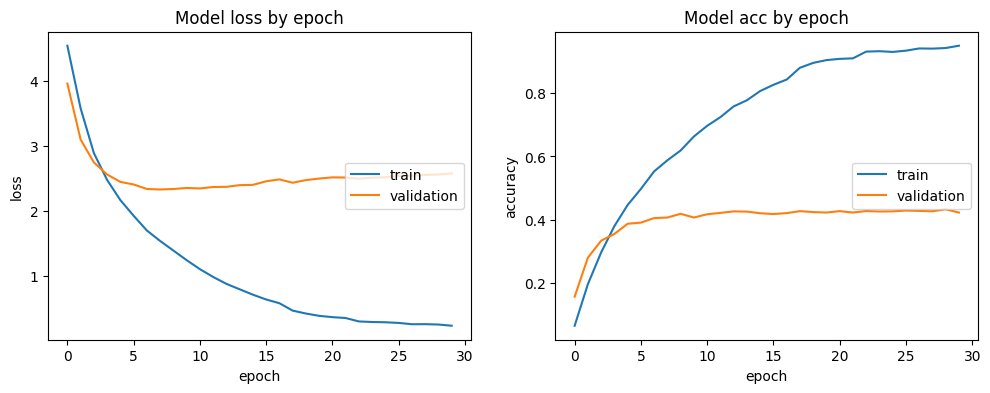

In [15]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')
plt.show()

In [ ]:
model.save('../models/model_127_species_exp2.h5')

: 